# Sentiment Classification & How To "Frame Problems" for a Neural Network

by Andrew Trask

- **Twitter**: @iamtrask
- **Blog**: http://iamtrask.github.io

In [1]:
from collections import Counter
import time
import sys
import numpy as np
from IPython.display import Image

## Curate a Dataset<a id='lesson_1'></a>
The cells from here until Project 1 include code Andrew shows in the videos leading up to mini project 1. We've included them so you can run the code along with the videos without having to type in everything.

In [2]:
def pretty_print_review_and_label(i):
    print(labels[i] + "\t:\t" + reviews[i][:80] + "...")

g = open('data/reviews.txt','r') # features
reviews = list(map(lambda x:x[:-1],g.readlines()))
g.close()

g = open('data/labels.txt','r') # labels
labels = list(map(lambda x:x[:-1].upper(),g.readlines()))
g.close()

**Note:** The data in `reviews.txt` we're using has already been preprocessed a bit and contains only lower case characters. If we were working from raw data, where we didn't know it was all lower case, we would want to add a step here to convert it. That's so we treat different variations of the same word, like `The`, `the`, and `THE`, all the same way.

In [3]:
# Check the number of reviews
len(reviews)

25000

In [4]:
# Check one instance
reviews[0]

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   '

In [5]:
labels[0]

'POSITIVE'

## Develop a Predictive Theory<a id='lesson_2'></a>

In [6]:
print("labels.txt \t : \t reviews.txt\n")
pretty_print_review_and_label(2137)
pretty_print_review_and_label(12816)
pretty_print_review_and_label(6267)
pretty_print_review_and_label(21934)
pretty_print_review_and_label(5297)
pretty_print_review_and_label(4998)

labels.txt 	 : 	 reviews.txt

NEGATIVE	:	this movie is terrible but it has some good effects .  ...
POSITIVE	:	adrian pasdar is excellent is this film . he makes a fascinating woman .  ...
NEGATIVE	:	comment this movie is impossible . is terrible  very improbable  bad interpretat...
POSITIVE	:	excellent episode movie ala pulp fiction .  days   suicides . it doesnt get more...
NEGATIVE	:	if you haven  t seen this  it  s terrible . it is pure trash . i saw this about ...
POSITIVE	:	this schiffer guy is a real genius  the movie is of excellent quality and both e...


**Observation:** Certain words seem to be associated with one of the two label types (e.g. excellent with POSITIVE and terrible with NEGATIVE). We will validate this in the next section.

### Quick Theory Validation<a id='project_1'></a>

Look for strong correlations of certain words with either negative or positive reviews.

We'll create three `Counter` objects, one for words from postive reviews, one for words from negative reviews, and one for all the words.

In [7]:
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

# Concatenate reviews to long strings
positive_reviews = []
negative_reviews = []

for label, review in zip(labels, reviews):
    if label == 'POSITIVE':
        positive_reviews.append(review)
    else:
        negative_reviews.append(review)
        
assert len(positive_reviews) + len(negative_reviews) == 25000, "reviews are missing"

print("positive reviews:", len(positive_reviews))
print("negative_reviews:", len(negative_reviews))


# Create lists of words
positive_str = ' '.join(positive_reviews)
negative_str = ' '.join(negative_reviews)
total_str = ' '.join(reviews)

print(len(positive_str))
print(len(negative_str))
print(len(total_str))

positive_words = positive_str.split(' ')
negative_words = negative_str.split(' ')
total_words = total_str.split(' ')

positive reviews: 12500
negative_reviews: 12500
17107791
16570474
33678266


In [8]:
# Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
for word in positive_words:
    positive_counts[word] += 1
for word in negative_words:
    negative_counts[word] += 1
for word in total_words:
    total_counts[word] += 1

Run the following two cells to list the words used in positive reviews and negative reviews, respectively, ordered from most to least commonly used. 

In [9]:
# Examine the counts of the most common words in positive reviews
print(positive_counts.most_common(5))
print(negative_counts.most_common(5))

[('', 550468), ('the', 173324), ('.', 159654), ('and', 89722), ('a', 83688)]
[('', 561462), ('.', 167538), ('the', 163389), ('a', 79321), ('and', 74385)]


**Observation:** As can be seen, common words like "the" appear very often in both positive and negative reviews. Instead of finding the most common words in positive or negative reviews, what you really want are the words found in positive reviews more often than in negative reviews, and vice versa. To accomplish this, you'll need to calculate the **ratios** of word usage between positive and negative reviews.

>The positive-to-negative ratio for a given word can be calculated with `positive_counts[word] / float(negative_counts[word]+1)`. Notice the `+1` in the denominator – that ensures we don't divide by zero for words that are only seen in positive reviews.

In [10]:
# Only analyze common words, that have been used at least 100 times
most_common_words = [a for a, b in dict(total_counts).items() if b >= 100]

# Check results
print(len(most_common_words))

4276


In [11]:
# Create Counter object to store positive/negative ratios of the most common words
pos_neg_ratios = Counter()


# Calculate the ratios of positive and negative uses of the most common words
for word in most_common_words:
    pos_neg_ratios[word] = positive_counts[word] / float(negative_counts[word] + 1)

Examine the ratios you've calculated for a few words:

In [12]:
print("Pos-to-neg ratio for 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio for 'amazing' = {}".format(pos_neg_ratios["amazing"]))
print("Pos-to-neg ratio for 'terrible' = {}".format(pos_neg_ratios["terrible"]))

Pos-to-neg ratio for 'the' = 1.0607993145235326
Pos-to-neg ratio for 'amazing' = 4.022813688212928
Pos-to-neg ratio for 'terrible' = 0.17744252873563218


Looking closely at the values you just calculated, we see the following:

* Words that you would expect to see more often in positive reviews – like "amazing" – have a ratio greater than 1. The more skewed a word is toward postive, the farther from 1 its positive-to-negative ratio  will be.
* Words that you would expect to see more often in negative reviews – like "terrible" – have positive values that are less than 1. The more skewed a word is toward negative, the closer to zero its positive-to-negative ratio will be.
* Neutral words, which don't really convey any sentiment because you would expect to see them in all sorts of reviews – like "the" – have values very close to 1. A perfectly neutral word – one that was used in exactly the same number of positive reviews as negative reviews – would be almost exactly 1. The `+1` we suggested you add to the denominator slightly biases words toward negative, but it won't matter because it will be a tiny bias and later we'll be ignoring words that are too close to neutral anyway.

Ok, the ratios tell us which words are used more often in postive or negative reviews, but the specific values we've calculated are a bit difficult to work with. A very positive word like "amazing" has a value above 4, whereas a very negative word like "terrible" has a value around 0.18. Those values aren't easy to compare for a couple of reasons:

* Right now, 1 is considered neutral, but the absolute value of the postive-to-negative rations of very postive words is larger than the absolute value of the ratios for the very negative words. So there is no way to directly compare two numbers and see if one word conveys the same magnitude of positive sentiment as another word conveys negative sentiment. So we should center all the values around netural so the absolute value fro neutral of the postive-to-negative ratio for a word would indicate how much sentiment (positive or negative) that word conveys.
* When comparing absolute values it's easier to do that around zero than one. 

To fix these issues, we'll convert all of our ratios to new values using _logarithms._

In the end, extremely positive and extremely negative words will have positive-to-negative ratios with similar magnitudes but opposite signs.

In [13]:
# Convert ratios to logs
for key, val in pos_neg_ratios.items():
    pos_neg_ratios[key] = np.log(val)
    
# Check results
print("Pos-to-neg ratio for 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio for 'amazing' = {}".format(pos_neg_ratios["amazing"]))
print("Pos-to-neg ratio for 'terrible' = {}".format(pos_neg_ratios["terrible"]))

Pos-to-neg ratio for 'the' = 0.05902269426102881
Pos-to-neg ratio for 'amazing' = 1.3919815802404802
Pos-to-neg ratio for 'terrible' = -1.7291085042663878


If everything worked, now you should see neutral words with values close to zero. In this case, "the" is near zero but slightly positive, so it was probably used in more positive reviews than negative reviews. But look at "amazing"'s ratio - it's above `1`, showing it is clearly a word with positive sentiment. And "terrible" has a similar score, but in the opposite direction, so it's below `-1`. It's now clear that both of these words are associated with specific, opposing sentiments.

In [14]:
# Words most frequently seen in a review with a "POSITIVE" label
pos_neg_ratios.most_common()[:30]

[('edie', 4.6913478822291435),
 ('paulie', 4.07753744390572),
 ('felix', 3.152736022363656),
 ('polanski', 2.8233610476132043),
 ('matthau', 2.80672172860924),
 ('victoria', 2.681021528714291),
 ('mildred', 2.6026896854443837),
 ('gandhi', 2.538973871058276),
 ('flawless', 2.451005098112319),
 ('superbly', 2.26002547857525),
 ('perfection', 2.159484249353372),
 ('astaire', 2.1400661634962708),
 ('captures', 2.038619547159581),
 ('voight', 2.030170492673053),
 ('wonderfully', 2.0218960560332353),
 ('powell', 1.978345424808467),
 ('brosnan', 1.9547990964725592),
 ('lily', 1.9203768470501485),
 ('bakshi', 1.9029851043382795),
 ('lincoln', 1.9014583864844796),
 ('refreshing', 1.8551812956655511),
 ('breathtaking', 1.8481124057791867),
 ('bourne', 1.8478489358790986),
 ('lemmon', 1.8458266904983307),
 ('delightful', 1.8002701588959635),
 ('flynn', 1.7996646487351682),
 ('andrews', 1.7764919970972666),
 ('homer', 1.7692866133759964),
 ('beautifully', 1.7626953362841438),
 ('soccer', 1.757857

In [15]:
# Words most frequently seen in a review with a "NEGATIVE" label
pos_neg_ratios.most_common()[:-31:-1]

[('boll', -4.969813299576001),
 ('uwe', -4.624972813284271),
 ('seagal', -3.644143560272545),
 ('unwatchable', -3.258096538021482),
 ('stinker', -3.2088254890146994),
 ('mst', -2.9502698994772336),
 ('incoherent', -2.9368917735310576),
 ('unfunny', -2.6922395950755678),
 ('waste', -2.6193845640165536),
 ('blah', -2.5704288232261625),
 ('horrid', -2.4849066497880004),
 ('pointless', -2.4553061800117097),
 ('atrocious', -2.4259083090260445),
 ('redeeming', -2.3682390632154826),
 ('prom', -2.3608540011180215),
 ('drivel', -2.3470368555648795),
 ('lousy', -2.307572634505085),
 ('worst', -2.286987896180378),
 ('laughable', -2.264363880173848),
 ('awful', -2.227194247027435),
 ('poorly', -2.2207550747464135),
 ('wasting', -2.204604684633842),
 ('remotely', -2.1972245773362196),
 ('existent', -2.0794415416798357),
 ('boredom', -1.995100393246085),
 ('miserably', -1.9924301646902063),
 ('sucks', -1.987068221548821),
 ('uninspired', -1.9832976811269336),
 ('lame', -1.981767458946166),
 ('insult

## Transforming Text into Numbers<a id='lesson_3'></a>
The cells here include code Andrew shows in the next video. We've included it so you can run the code along with the video without having to type in everything.

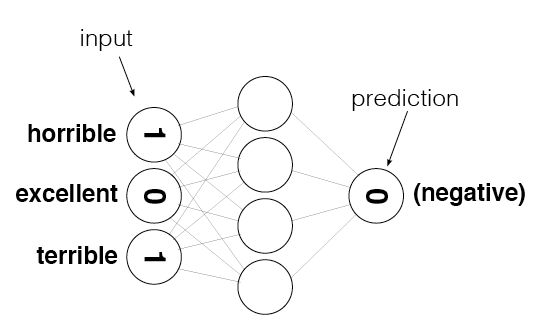

In [16]:
review = "This was a horrible, terrible movie."
Image(filename='pics/sentiment_network.png')

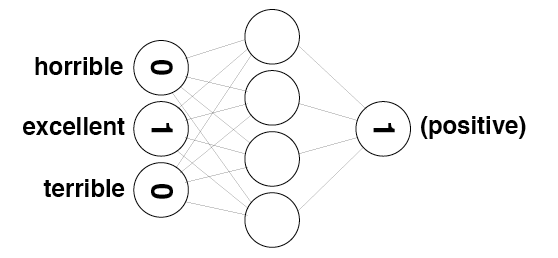

In [17]:
review = "The movie was excellent"
Image(filename='pics/sentiment_network_pos.png')

### Create the Input/Output Data

**TODO:** Create a [set](https://docs.python.org/3/tutorial/datastructures.html#sets) named `vocab` that contains every word in the vocabulary.

In [18]:
# Create a set named "vocab" containing all of the words from all of the reviews
vocab = set(total_counts.keys())

Run the following cell to check your vocabulary size. If everything worked correctly, it should print **74074**

In [19]:
vocab_size = len(vocab)
print(vocab_size)

74074


Take a look at the following image. It represents the layers of the neural network you'll be building throughout this notebook. `layer_0` is the input layer, `layer_1` is a hidden layer, and `layer_2` is the output layer.

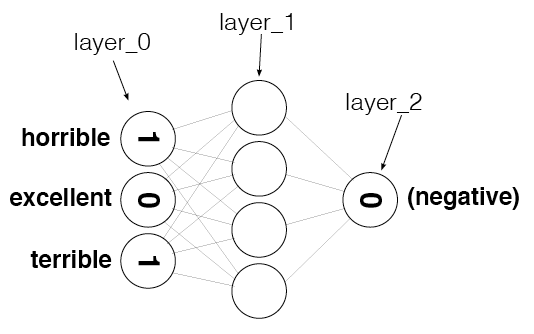

In [20]:
Image(filename='pics/sentiment_network_2.png')

**TODO:** Create a numpy array called `layer_0` and initialize it to all zeros. You will find the [zeros](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html) function particularly helpful here. Be sure you create `layer_0` as a 2-dimensional matrix with 1 row and `vocab_size` columns. 

In [21]:
# Create layer_0 matrix with the two dimensions 1 by vocab_size, initially filled with zeros
layer_0 = np.zeros(vocab_size).reshape(1,vocab_size)

# Check results
print(layer_0.shape)

(1, 74074)


`layer_0` contains one entry for every word in the vocabulary. We need to make sure we know the index of each word, so run the following cell to create a lookup table that stores the index of every word.

In [22]:
# Create a dictionary of words in the vocabulary mapped to index positions
# (to be used in layer_0)
word2index = {}
for i, word in enumerate(vocab):
    word2index[word] = i
    
# display the map of words to indices
word2index

{'': 0,
 'shoving': 1,
 'frenchy': 2,
 'defame': 3,
 'palde': 4,
 'stirling': 5,
 'propitious': 6,
 'goddard': 7,
 'officialdom': 8,
 'innes': 9,
 'rs': 10,
 'mandu': 11,
 'swoons': 12,
 'nicely': 13,
 'sofa': 14,
 'talespin': 15,
 'distracted': 16,
 'storyboring': 17,
 'exploiting': 18,
 'unplayable': 19,
 'blucher': 20,
 'repulsively': 21,
 'organically': 22,
 'larocque': 23,
 'phile': 24,
 'realist': 25,
 'probability': 26,
 'sholay': 27,
 'skycaptain': 28,
 'jrg': 29,
 'nadeem': 30,
 'aly': 31,
 'bullied': 32,
 'dissolved': 33,
 'wvs': 34,
 'hatty': 35,
 'imbroglio': 36,
 'mhatre': 37,
 'bodden': 38,
 'paydirt': 39,
 'entities': 40,
 'jenkins': 41,
 'liga': 42,
 'searchlight': 43,
 'hurricane': 44,
 'duality': 45,
 'jin': 46,
 'iffr': 47,
 'rav': 48,
 'chains': 49,
 'curses': 50,
 'oftentimes': 51,
 'subscribed': 52,
 'provo': 53,
 'punjab': 54,
 'htv': 55,
 'moderators': 56,
 'delegation': 57,
 'defensive': 58,
 'platte': 59,
 'goldustluna': 60,
 'pursuant': 61,
 'sleepy': 62,
 'm

**TODO:**  Complete the implementation of `update_input_layer`. It should count 
          how many times each word is used in the given review, and then store
          those counts at the appropriate indices inside `layer_0`.

In [23]:
def update_input_layer(review):
    """ Modify the global layer_0 to represent the vector form of review.
    The element at a given index of layer_0 should represent
    how many times the given word occurs in the review.
    Args:
        review(string) - the string of the review
    Returns:
        None
    """
    global layer_0
    # clear out previous state by resetting the layer to be all 0s
    layer_0 *= 0
    
    # Count how many times each word is used in the given review and store the results in layer_0
    for word in review.split(" "):
        layer_0[0, word2index[word]] += 1

Run the following cell to test updating the input layer with the first review. The indices assigned may not be the same as in the solution, but hopefully you'll see some non-zero values in `layer_0`.  

In [24]:
# Check results
update_input_layer(reviews[0])
layer_0

array([[18.,  0.,  0., ...,  0.,  0.,  0.]])

**TODO:** Complete the implementation of `get_target_for_labels`. It should return `0` or `1`, 
          depending on whether the given label is `NEGATIVE` or `POSITIVE`, respectively.

In [25]:
def get_target_for_label(label):
    """Convert a label to `0` or `1`.
    Args:
        label(string) - Either "POSITIVE" or "NEGATIVE".
    Returns:
        `0` or `1`.
    """
    if label.lower() == "positive":
        return 1
    else:
        return 0

Run the following two cells. They should print out`'POSITIVE'` and `1`, respectively.

In [26]:
# Check results
print(get_target_for_label(labels[0]))  # pos
print(get_target_for_label(labels[1]))  # neg

1
0


## Build the Neural Network

**TODO:** 
- Create a basic neural network with an input layer, a hidden layer, and an output layer. (Do **not** add a non-linearity in the hidden layer. That is, do not use an activation function when calculating the hidden layer outputs.)
- Re-use the code from earlier in this notebook to create the training data
- Implement the `pre_process_data` function to create the vocabulary for our training data generating functions
- Ensure `train` trains over the entire corpus

In [27]:
import time
import sys
import numpy as np

# Encapsulate our neural network in a class
class SentimentNetwork:
    
    def __init__(self, reviews, labels, hidden_nodes = 10, learning_rate = 0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        """
        
        # Assign a seed for reproducable results during development 
        np.random.seed(1)
        # Process the reviews and associated labels
        self.pre_process_data(reviews, labels)     
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    def pre_process_data(self, reviews, labels):
        
        # Populate review_vocab with all of the words in the given reviews
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                review_vocab.add(word)
        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        # Populate label_vocab with all of the words in the given labels.
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i     
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        # Store the number of nodes in input, hidden, and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize self.weights_0_1 (between input and hidden) as a matrix of zeros.
        self.weights_0_1 = np.zeros((self.input_nodes, self.hidden_nodes))
        
        # Initialize self.weights_1_2 (between hidden and output) as a matrix of random values. 
        self.weights_1_2 = np.random.normal(0.0, self.hidden_nodes**-0.5,
                                            (self.hidden_nodes, self.output_nodes))
        
        # Create the input layer, a matrix with shape 1 x input_nodes initialized to zero
        self.layer_0 = np.zeros((1, input_nodes))
        
    def update_input_layer(self,review):

        self.layer_0 *= 0  # reset to zero
        for word in review.split(" "):
            if word in self.word2index.keys():
                self.layer_0[0, word2index[word]] += 1
                
    def get_target_for_label(self,label):
        if label.lower() == "positive":
            return 1
        else:
            return 0
        
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self,output):
        return output * (1 - output)

    def train(self, training_reviews, training_labels):
        
        assert(len(training_reviews) == len(training_labels))
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0
        # Remember when we started for printing time statistics
        start = time.time()
        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # Get the next review and its correct label
            review = training_reviews[i]
            label = training_labels[i]
            
            # Implement the forward pass through the network. 
            # That means use the given review to update the input layer, 
            # then calculate values for the hidden layer,
            # and finally calculate the output layer.
            # Do not use an activation function for the hidden layer,
            # but use the sigmoid activation function for the output layer.
            self.update_input_layer(review)
            layer_1 = np.dot(self.layer_0, self.weights_0_1)  # no activation
            layer_2 = self.sigmoid(np.dot(layer_1, self.weights_1_2))
            
            # Implement the back propagation pass here. 
            # That means calculate the error for the forward pass's prediction
            # and update the weights in the network according to their
            # contributions toward the error, as calculated via the
            # gradient descent and back propagation algorithms.
            layer_2_error = layer_2 - self.get_target_for_label(label)
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)
            
            layer_1_error = np.dot(layer_2_delta, self.weights_1_2.T)
            layer_1_delta = layer_1_error # no activation here
            
            self.weights_0_1 -= np.dot(self.layer_0.T, layer_1_delta) * self.learning_rate
            self.weights_1_2 -= np.dot(layer_1.T, layer_2_delta) * self.learning_rate
            
            
            # Keep track of correct predictions, print out prediction accuracy and speed 
            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
                
            
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # Keep track of how many correct predictions we make
        correct = 0
        # Time how many predictions per second we make
        start = time.time()

        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        # Run a forward pass through the network. Note: The review passed into this 
        # function for prediction might come from anywhere, so you should convert it 
        # to lower case prior to using it.
        self.update_input_layer(review.lower())
        layer_1 = np.dot(self.layer_0, self.weights_0_1)  # no activation
        layer_2 = self.sigmoid(np.dot(layer_1, self.weights_1_2))
        
        if layer_2[0] >= 0.5:
            return "POSITIVE"
        else:
            return "NEGATIVE"

Run the following cell to create a `SentimentNetwork` that will train on all but the last 1000 reviews (we're saving those for testing). Here we use a learning rate of `0.1`.

In [59]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000], learning_rate=0.1)

Run the following cell to test the network's performance against the last 1000 reviews (the ones we held out from our training set). **We have not trained the model yet, so the results should be about 50% as it will just be guessing and there are only two possible values to choose from.**

In [60]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:13.9% Speed(reviews/sec):741.3 #Correct:70 #Tested:140 Testing Accuracy:50.0%

Progress:26.0% Speed(reviews/sec):713.2 #Correct:131 #Tested:261 Testing Accuracy:50.1%

Progress:38.3% Speed(reviews/sec):693.4 #Correct:192 #Tested:384 Testing Accuracy:50.0%

Progress:50.6% Speed(reviews/sec):680.4 #Correct:254 #Tested:507 Testing Accuracy:50.0%

Progress:63.1% Speed(reviews/sec):679.9 #Correct:316 #Tested:632 Testing Accuracy:50.0%

Progress:79.2% Speed(reviews/sec):704.0 #Correct:397 #Tested:793 Testing Accuracy:50.0%

Progress:92.9% Speed(reviews/sec):712.9 #Correct:465 #Tested:930 Testing Accuracy:50.0%

Progress:99.9% Speed(reviews/sec):721.0 #Correct:500 #Tested:1000 Testing Accuracy:50.0%

Run the following cell to actually train the network. During training, it will display the model's accuracy repeatedly as it trains so you can see how well it's doing.

In [50]:
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):98.16 #Correct:1251 #Trained:2501 Training Accuracy:50.0%
Progress:20.8% Speed(reviews/sec):92.19 #Correct:2501 #Trained:5001 Training Accuracy:50.0%
Progress:22.0% Speed(reviews/sec):92.69 #Correct:2647 #Trained:5294 Training Accuracy:50.0%

KeyboardInterrupt: 

That most likely didn't train very well. Part of the reason may be because the learning rate is too high. Run the following cell to recreate the network with a smaller learning rate, `0.01`, and then train the new network.

In [61]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000], learning_rate=0.01)
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):113.8 #Correct:1366 #Trained:2501 Training Accuracy:54.6%
Progress:20.8% Speed(reviews/sec):103.6 #Correct:2934 #Trained:5001 Training Accuracy:58.6%
Progress:31.2% Speed(reviews/sec):95.97 #Correct:4598 #Trained:7501 Training Accuracy:61.2%
Progress:41.6% Speed(reviews/sec):92.05 #Correct:6328 #Trained:10001 Training Accuracy:63.2%
Progress:52.0% Speed(reviews/sec):89.10 #Correct:8091 #Trained:12501 Training Accuracy:64.7%
Progress:62.5% Speed(reviews/sec):86.96 #Correct:9877 #Trained:15001 Training Accuracy:65.8%
Progress:72.9% Speed(reviews/sec):87.65 #Correct:11644 #Trained:17501 Training Accuracy:66.5%
Progress:83.3% Speed(reviews/sec):88.17 #Correct:13496 #Trained:20001 Training Accuracy:67.4%
Progress:93.7% Speed(reviews/sec):88.54 #Correct:15348 #Trained:22501 Training Accuracy:68.2%
Progress:99.9% Speed(reviews/sec):88.58 #Correct:16495 #Trained:24000 Training A

## Reducing Neural Noise

The following cells show that the inputs with the heighest weighting (counts) are meaningless for our predictions which make training our NN hard. (Imagine that if `horrible` appears only 1x in the review but `the` appears 10x, then the input into the hidden layer is dominated by the latter as it multiplied with a factor of 10.)

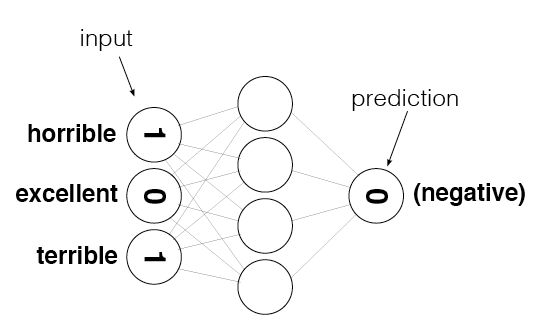

In [28]:
from IPython.display import Image
Image(filename='pics/sentiment_network.png')

In [29]:
def update_input_layer(review):
    
    global layer_0
    
    # clear out previous state, reset the layer to be all 0s
    layer_0 *= 0
    for word in review.split(" "):
        layer_0[0][word2index[word]] += 1

update_input_layer(reviews[0])

In [30]:
layer_0

array([[18.,  0.,  0., ...,  0.,  0.,  0.]])

The value of the first input seems to be dominating the input layer. What is it?

In [31]:
review_counter = Counter()

In [32]:
for word in reviews[0].split(" "):
    review_counter[word] += 1

In [33]:
review_counter.most_common()[:10]

[('.', 27),
 ('', 18),
 ('the', 9),
 ('to', 6),
 ('high', 5),
 ('i', 5),
 ('bromwell', 4),
 ('is', 4),
 ('a', 4),
 ('teachers', 4)]

**TODO:** Attempt to reduce the noise in the input data like Andrew did in the previous video. Specifically, do the following:
* Copy the `SentimentNetwork` class you created earlier into the following cell.
* Modify `update_input_layer` so it does not count how many times each word is used, but rather just stores whether or not a word was used. 

In [34]:
class SentimentNetwork:
    
    def __init__(self, reviews, labels, hidden_nodes = 10, learning_rate = 0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        """
        
        # Assign a seed for reproducable results during development 
        np.random.seed(1)
        # Process the reviews and associated labels
        self.pre_process_data(reviews, labels)     
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    def pre_process_data(self, reviews, labels):
        
        # Populate review_vocab with all of the words in the given reviews
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                review_vocab.add(word)
        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        # Populate label_vocab with all of the words in the given labels.
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i     
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        # Store the number of nodes in input, hidden, and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize self.weights_0_1 (between input and hidden) as a matrix of zeros.
        self.weights_0_1 = np.zeros((self.input_nodes, self.hidden_nodes))
        
        # Initialize self.weights_1_2 (between hidden and output) as a matrix of random values. 
        self.weights_1_2 = np.random.normal(0.0, self.hidden_nodes**-0.5,
                                            (self.hidden_nodes, self.output_nodes))
        
        # Create the input layer, a matrix with shape 1 x input_nodes initialized to zero
        self.layer_0 = np.zeros((1, input_nodes))
        
    def update_input_layer(self,review):

        self.layer_0 *= 0  # reset to zero
        for word in review.split(" "):
            if word in self.word2index.keys():
                self.layer_0[0, word2index[word]] = 1  # CHANGE - fixed to 1
                
    def get_target_for_label(self,label):
        if label.lower() == "positive":
            return 1
        else:
            return 0
        
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self,output):
        return output * (1 - output)

    def train(self, training_reviews, training_labels):
        
        assert(len(training_reviews) == len(training_labels))
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0
        # Remember when we started for printing time statistics
        start = time.time()
        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # Get the next review and its correct label
            review = training_reviews[i]
            label = training_labels[i]
            
            # Implement the forward pass through the network. 
            # That means use the given review to update the input layer, 
            # then calculate values for the hidden layer,
            # and finally calculate the output layer.
            # Do not use an activation function for the hidden layer,
            # but use the sigmoid activation function for the output layer.
            self.update_input_layer(review)
            layer_1 = np.dot(self.layer_0, self.weights_0_1)  # no activation
            layer_2 = self.sigmoid(np.dot(layer_1, self.weights_1_2))
            
            # Implement the back propagation pass here. 
            # That means calculate the error for the forward pass's prediction
            # and update the weights in the network according to their
            # contributions toward the error, as calculated via the
            # gradient descent and back propagation algorithms.
            layer_2_error = layer_2 - self.get_target_for_label(label)
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)
            
            layer_1_error = np.dot(layer_2_delta, self.weights_1_2.T)
            layer_1_delta = layer_1_error # no activation here
            
            self.weights_0_1 -= np.dot(self.layer_0.T, layer_1_delta) * self.learning_rate
            self.weights_1_2 -= np.dot(layer_1.T, layer_2_delta) * self.learning_rate
            
            
            # Keep track of correct predictions, print out prediction accuracy and speed 
            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
                
            
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # Keep track of how many correct predictions we make
        correct = 0
        # Time how many predictions per second we make
        start = time.time()

        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        # Run a forward pass through the network. Note: The review passed into this 
        # function for prediction might come from anywhere, so you should convert it 
        # to lower case prior to using it.
        self.update_input_layer(review.lower())
        layer_1 = np.dot(self.layer_0, self.weights_0_1)  # no activation
        layer_2 = self.sigmoid(np.dot(layer_1, self.weights_1_2))
        
        if layer_2[0] >= 0.5:
            return "POSITIVE"
        else:
            return "NEGATIVE"

Run the following cell to recreate the network and train it. Notice we've gone back to the higher learning rate of `0.1`.

In [69]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000], learning_rate=0.1)
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):101.3 #Correct:1949 #Trained:2501 Training Accuracy:77.9%
Progress:20.8% Speed(reviews/sec):94.24 #Correct:3994 #Trained:5001 Training Accuracy:79.8%
Progress:31.2% Speed(reviews/sec):92.91 #Correct:6121 #Trained:7501 Training Accuracy:81.6%
Progress:41.6% Speed(reviews/sec):95.17 #Correct:8278 #Trained:10001 Training Accuracy:82.7%
Progress:52.0% Speed(reviews/sec):93.65 #Correct:10439 #Trained:12501 Training Accuracy:83.5%
Progress:62.5% Speed(reviews/sec):93.73 #Correct:12580 #Trained:15001 Training Accuracy:83.8%
Progress:72.9% Speed(reviews/sec):94.77 #Correct:14694 #Trained:17501 Training Accuracy:83.9%
Progress:83.3% Speed(reviews/sec):95.67 #Correct:16868 #Trained:20001 Training Accuracy:84.3%
Progress:93.7% Speed(reviews/sec):96.40 #Correct:19055 #Trained:22501 Training Accuracy:84.6%
Progress:99.9% Speed(reviews/sec):96.75 #Correct:20375 #Trained:24000 Training

That should have trained much better than the earlier attempts. It's still not wonderful, but it should have improved dramatically. Run the following cell to test your model with 1000 predictions.

In [70]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:99.9% Speed(reviews/sec):787.8 #Correct:860 #Tested:1000 Testing Accuracy:86.0%

## Analyzing Inefficiencies in our Network: Tuning for Speed!

The following cells demonstrate the wasteful computation that goes on to calculate the hidden layer. The input consists of more the 74'000 words that are all multiplied with their count (0 or 1) times the nodes of the hidden layer. This is waste!

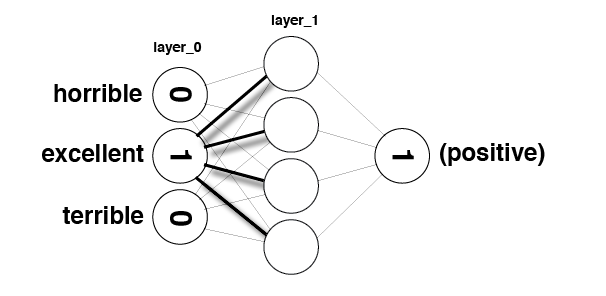

In [35]:
Image(filename='pics/sentiment_network_sparse.png')

In [36]:
"""Demonstrate how we calculate the hidden layer right now"""

# Input layer
layer_0 = np.zeros(10)
layer_0[4] = 1
layer_0[9] = 1
print(layer_0)

[0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]


In [37]:
# Weights
weights_0_1 = np.random.randn(10,5)
print(weights_0_1)

[[ 0.04866179  0.25737814 -1.29129042 -2.2509903   0.25073718]
 [-1.03991045 -0.92238426 -1.05017765  1.07988179  0.40794939]
 [-0.04594808 -0.68142343 -0.2455096  -1.48797361  0.96497363]
 [ 0.00518281 -0.9294178   1.34437386  1.03219613  0.7626204 ]
 [ 0.99961096  1.62810534 -1.54184408  1.87625683 -1.47166909]
 [ 1.3562034   0.96652816  1.87253636 -0.52340748  1.40191421]
 [-2.17283666 -0.37699462 -0.74044214  0.2018558   0.49857289]
 [-0.82504262 -0.22195319 -0.58878811  2.35338568 -0.47473981]
 [ 0.11779104 -0.58391406 -3.8616309   0.09323741 -1.17956825]
 [ 1.02578576  1.15829714 -1.34136349  0.76075863 -1.08548122]]


In [38]:
# Resulting hidden layer
print(np.dot(layer_0, weights_0_1))

[ 2.02539672  2.78640248 -2.88320757  2.63701545 -2.55715031]


In [39]:
"""Demonstrate what happens if we calculate only inputs with value != 0"""

indices = [4,9]
layer_1 = np.zeros(5)

for index in indices:
    layer_1 += (1 * weights_0_1[index])

print(layer_1) # Same result with much less computation

[ 2.02539672  2.78640248 -2.88320757  2.63701545 -2.55715031]


In [40]:
"""Demonstrate that we don't have to mulitply the remaining inputs with 1"""

indices = [4,9]
layer_1 = np.zeros(5)

for index in indices:
    layer_1 += weights_0_1[index]  # just summing up

print(layer_1) # Same result with even less computation

[ 2.02539672  2.78640248 -2.88320757  2.63701545 -2.55715031]


**TODO:** Make the `SentimentNetwork` class more efficient by eliminating unnecessary multiplications and additions that occur during forward and backward propagation. To do that, you can do the following:
* Copy the `SentimentNetwork` class from the previous project into the following cell.
* Remove the `update_input_layer` function - you will not need it in this version.
* Modify `init_network`:
>* You no longer need a separate input layer, so remove any mention of `self.layer_0`
>* You will be dealing with the old hidden layer more directly, so create `self.layer_1`, a two-dimensional matrix with shape 1 x hidden_nodes, with all values initialized to zero
* Modify `train`:
>* Change the name of the input parameter `training_reviews` to `training_reviews_raw`. This will help with the next step.
>* At the beginning of the function, you'll want to preprocess your reviews to convert them to a list of indices (from `word2index`) that are actually used in the review. This is equivalent to what you saw in the video when Andrew set specific indices to 1. Your code should create a local `list` variable named `training_reviews` that should contain a `list` for each review in `training_reviews_raw`. Those lists should contain the indices for words found in the review.
>* Remove call to `update_input_layer`
>* Use `self`'s  `layer_1` instead of a local `layer_1` object.
>* In the forward pass, replace the code that updates `layer_1` with new logic that only adds the weights for the indices used in the review.
>* When updating `weights_0_1`, only update the individual weights that were used in the forward pass.
* Modify `run`:
>* Remove call to `update_input_layer` 
>* Use `self`'s  `layer_1` instead of a local `layer_1` object.
>* Much like you did in `train`, you will need to pre-process the `review` so you can work with word indices, then update `layer_1` by adding weights for the indices used in the review.

**Note:** We now completely skip the input layer weight calculations, as we can input the relevant inputs directly into the hidden layer!

In [49]:
class SentimentNetwork:
    
    def __init__(self, reviews, labels, hidden_nodes = 10, learning_rate = 0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        """
        
        # Assign a seed for reproducable results during development 
        np.random.seed(1)
        # Process the reviews and associated labels
        self.pre_process_data(reviews, labels)     
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    def pre_process_data(self, reviews, labels):
        
        # Populate review_vocab with all of the words in the given reviews
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                review_vocab.add(word)
        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        # Populate label_vocab with all of the words in the given labels.
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i     
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        # Store the number of nodes in input, hidden, and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize self.weights_0_1 (between input and hidden) as a matrix of zeros.
        self.weights_0_1 = np.zeros((self.input_nodes, self.hidden_nodes))
        
        # Initialize self.weights_1_2 (between hidden and output) as a matrix of random values. 
        self.weights_1_2 = np.random.normal(0.0, self.hidden_nodes**-0.5,
                                            (self.hidden_nodes, self.output_nodes))
        
        # Create the input layer, a matrix with shape 1 x input_nodes initialized to zero
        self.layer_1 = np.zeros((1, hidden_nodes))  # CHANGE
                
    def get_target_for_label(self,label):
        if label.lower() == "positive":
            return 1
        else:
            return 0
        
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self,output):
        return output * (1 - output)

    def train(self, training_reviews_raw, training_labels):
        
        # THIS IS NEW
        training_reviews = list()
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(" "):
                if(word in self.word2index.keys()):
                    indices.add(self.word2index[word])
            training_reviews.append(list(indices))
        
        assert(len(training_reviews) == len(training_labels))
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0
        # Remember when we started for printing time statistics
        start = time.time()
        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # Get the next review and its correct label
            review = training_reviews[i]
            label = training_labels[i]
            
            # Implement the forward pass through the network. 
            # THIS IS NEW
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]                    
            
            layer_2 = self.sigmoid(np.dot(self.layer_1, self.weights_1_2))
            
            # Implement the back propagation pass here. 
            # That means calculate the error for the forward pass's prediction
            # and update the weights in the network according to their
            # contributions toward the error, as calculated via the
            # gradient descent and back propagation algorithms.
            layer_2_error = layer_2 - self.get_target_for_label(label)
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)
            
            layer_1_error = np.dot(layer_2_delta, self.weights_1_2.T)
            layer_1_delta = layer_1_error # no activation here
            
            # THIS IS NEW
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate
            self.weights_1_2 -= np.dot(self.layer_1.T, layer_2_delta) * self.learning_rate
            
            # Keep track of correct predictions, print out prediction accuracy and speed 
            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
                
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if i % 2500 == 0 and elapsed_time > 5:
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # Keep track of how many correct predictions we make
        correct = 0
        # Time how many predictions per second we make
        start = time.time()

        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        self.layer_1 *= 0
        unique_indices = set()
        for word in review.lower().split(" "):
            if word in self.word2index.keys():
                unique_indices.add(self.word2index[word])
        
        for index in unique_indices:
            self.layer_1 += self.weights_0_1[index]
        layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
        
        if(layer_2[0] >= 0.5):
            return "POSITIVE"
        else:
            return "NEGATIVE"

Run the following cell to recreate the network and train it once again.

In [50]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000], learning_rate=0.1)
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.48% Speed(reviews/sec):623.4 #Correct:77 #Trained:118 Training Accuracy:65.2%

Progress:1.15% Speed(reviews/sec):675.0 #Correct:198 #Trained:277 Training Accuracy:71.4%

Progress:1.57% Speed(reviews/sec):638.4 #Correct:278 #Trained:380 Training Accuracy:73.1%

Progress:2.12% Speed(reviews/sec):651.9 #Correct:373 #Trained:512 Training Accuracy:72.8%

Progress:2.69% Speed(reviews/sec):661.5 #Correct:472 #Trained:647 Training Accuracy:72.9%

Progress:3.15% Speed(reviews/sec):652.5 #Correct:552 #Trained:758 Training Accuracy:72.8%

Progress:3.60% Speed(reviews/sec):642.6 #Correct:637 #Trained:866 Training Accuracy:73.5%

Progress:4.11% Speed(reviews/sec):645.8 #Correct:735 #Trained:988 Training Accuracy:74.3%

Progress:4.72% Speed(reviews/sec):653.7 #Correct:859 #Trained:1136 Training Accuracy:75.6%

Progress:5.19% Speed(reviews/sec):647.8 #Correct:944 #Trained:1247 Training Accuracy:75.7%

Progress:5.75% Speed(reviews/sec):654.2 #Correct:1052 #Trained:1381 Training Accuracy:76.1%

Progress:6.31% Speed(reviews/sec):657.2 #Correct:1151 #Trained:1517 Training Accuracy:75.8%

Progress:6.81% Speed(reviews/sec):657.7 #Correct:1245 #Trained:1636 Training Accuracy:76.1%

Progress:7.28% Speed(reviews/sec):653.0 #Correct:1340 #Trained:1749 Training Accuracy:76.6%

Progress:7.93% Speed(reviews/sec):663.8 #Correct:1461 #Trained:1905 Training Accuracy:76.6%

Progress:8.55% Speed(reviews/sec):673.2 #Correct:1582 #Trained:2054 Training Accuracy:77.0%

Progress:9.10% Speed(reviews/sec):674.8 #Correct:1696 #Trained:2186 Training Accuracy:77.5%

Progress:20.8% Speed(reviews/sec):621.9 #Correct:3994 #Trained:5001 Training Accuracy:79.8%
Progress:31.2% Speed(reviews/sec):628.6 #Correct:6121 #Trained:7501 Training Accuracy:81.6%
Progress:41.6% Speed(reviews/sec):629.3 #Correct:8278 #Trained:10001 Training Accuracy:82.7%
Progress:52.0% Speed(reviews/sec):611.6 #Correct:10439 #Trained:12501 Training Accuracy:83.5%
Progress:62.5% Speed(reviews/sec):616.0 #Correct:12580 #Trained:15001 Training Accuracy:83.8%
Progress:72.9% Speed(reviews/sec):620.8 #Correct:14694 #Trained:17501 Training Accuracy:83.9%
Progress:83.3% Speed(reviews/sec):621.2 #Correct:16868 #Trained:20001 Training Accuracy:84.3%
Progress:93.7% Speed(reviews/sec):622.7 #Correct:19055 #Trained:22501 Training Accuracy:84.6%
Progress:99.9% Speed(reviews/sec):625.1 #Correct:20375 #Trained:24000 Training Accuracy:84.8%

That should have trained much better than the earlier attempts. Run the following cell to test your model with 1000 predictions.

In [51]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:31.6% Speed(reviews/sec):1541. #Correct:279 #Tested:317 Testing Accuracy:88.0%

Progress:57.4% Speed(reviews/sec):1448. #Correct:510 #Tested:575 Testing Accuracy:88.6%

Progress:79.9% Speed(reviews/sec):1342. #Correct:688 #Tested:800 Testing Accuracy:86.0%

Progress:96.0% Speed(reviews/sec):1227. #Correct:823 #Tested:961 Testing Accuracy:85.6%

Progress:99.9% Speed(reviews/sec):1194. #Correct:860 #Tested:1000 Testing Accuracy:86.0%

## Further Noise Reduction

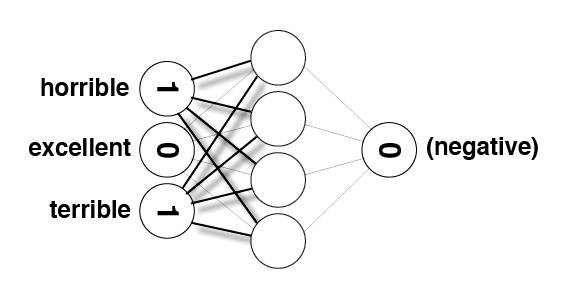

In [29]:
Image(filename='pics/sentiment_network_sparse_2.png')

In [30]:
# Words most frequently seen in a review with a "POSITIVE" label
pos_neg_ratios.most_common()[:30]

[('edie', 4.6913478822291435),
 ('paulie', 4.07753744390572),
 ('felix', 3.152736022363656),
 ('polanski', 2.8233610476132043),
 ('matthau', 2.80672172860924),
 ('victoria', 2.681021528714291),
 ('mildred', 2.6026896854443837),
 ('gandhi', 2.538973871058276),
 ('flawless', 2.451005098112319),
 ('superbly', 2.26002547857525),
 ('perfection', 2.159484249353372),
 ('astaire', 2.1400661634962708),
 ('captures', 2.038619547159581),
 ('voight', 2.030170492673053),
 ('wonderfully', 2.0218960560332353),
 ('powell', 1.978345424808467),
 ('brosnan', 1.9547990964725592),
 ('lily', 1.9203768470501485),
 ('bakshi', 1.9029851043382795),
 ('lincoln', 1.9014583864844796),
 ('refreshing', 1.8551812956655511),
 ('breathtaking', 1.8481124057791867),
 ('bourne', 1.8478489358790986),
 ('lemmon', 1.8458266904983307),
 ('delightful', 1.8002701588959635),
 ('flynn', 1.7996646487351682),
 ('andrews', 1.7764919970972666),
 ('homer', 1.7692866133759964),
 ('beautifully', 1.7626953362841438),
 ('soccer', 1.757857

In [31]:
# words most frequently seen in a review with a "NEGATIVE" label
list(reversed(pos_neg_ratios.most_common()))[0:30]

[('boll', -4.969813299576001),
 ('uwe', -4.624972813284271),
 ('seagal', -3.644143560272545),
 ('unwatchable', -3.258096538021482),
 ('stinker', -3.2088254890146994),
 ('mst', -2.9502698994772336),
 ('incoherent', -2.9368917735310576),
 ('unfunny', -2.6922395950755678),
 ('waste', -2.6193845640165536),
 ('blah', -2.5704288232261625),
 ('horrid', -2.4849066497880004),
 ('pointless', -2.4553061800117097),
 ('atrocious', -2.4259083090260445),
 ('redeeming', -2.3682390632154826),
 ('prom', -2.3608540011180215),
 ('drivel', -2.3470368555648795),
 ('lousy', -2.307572634505085),
 ('worst', -2.286987896180378),
 ('laughable', -2.264363880173848),
 ('awful', -2.227194247027435),
 ('poorly', -2.2207550747464135),
 ('wasting', -2.204604684633842),
 ('remotely', -2.1972245773362196),
 ('existent', -2.0794415416798357),
 ('boredom', -1.995100393246085),
 ('miserably', -1.9924301646902063),
 ('sucks', -1.987068221548821),
 ('uninspired', -1.9832976811269336),
 ('lame', -1.981767458946166),
 ('insult

In [32]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [33]:
hist, edges = np.histogram(list(map(lambda x:x[1],pos_neg_ratios.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="Word Positive/Negative Affinity Distribution")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

C:\Users\r2d4\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The normed argument is ignored when density is provided. In future passing both will result in an error.
  """Entry point for launching an IPython kernel.


In [34]:
frequency_frequency = Counter()

for word, cnt in total_counts.most_common():
    frequency_frequency[cnt] += 1

In [35]:
hist, edges = np.histogram(list(map(lambda x:x[1],frequency_frequency.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="The frequency distribution of the words in our corpus")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

C:\Users\r2d4\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The normed argument is ignored when density is provided. In future passing both will result in an error.
  """Entry point for launching an IPython kernel.


### Reduce Noise by Strategically Reducing the Vocabulary<a id='project_6'></a>

**TODO:** Improve `SentimentNetwork`'s performance by reducing more noise in the vocabulary. Specifically, do the following:
* Copy the `SentimentNetwork` class from the previous project into the following cell.
* Modify `pre_process_data`:
>* Add two additional parameters: `min_count` and `polarity_cutoff`
>* Calculate the positive-to-negative ratios of words used in the reviews. (You can use code you've written elsewhere in the notebook, but we are moving it into the class like we did with other helper code earlier.)
>* Andrew's solution only calculates a postive-to-negative ratio for words that occur at least 50 times. This keeps the network from attributing too much sentiment to rarer words. You can choose to add this to your solution if you would like.  
>* Change so words are only added to the vocabulary if they occur in the vocabulary more than `min_count` times.
>* Change so words are only added to the vocabulary if the absolute value of their postive-to-negative ratio is at least `polarity_cutoff`
* Modify `__init__`:
>* Add the same two parameters (`min_count` and `polarity_cutoff`) and use them when you call `pre_process_data`

In [61]:
class SentimentNetwork:
    
    def __init__(self, reviews, labels, min_count, polarity_cutoff, hidden_nodes=10, learning_rate=0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        """
        
        # Assign a seed for reproducable results during development 
        np.random.seed(1)
        # Process the reviews and associated labels
        self.pre_process_data(reviews, labels, min_count, polarity_cutoff)     
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    def pre_process_data(self, reviews, labels, polarity_cutoff, min_count):
        
        ## ----------------------------------------
        ## New for Project 6: Calculate positive-to-negative ratios for words before
        #                     building vocabulary
        #
        positive_counts = Counter()
        negative_counts = Counter()
        total_counts = Counter()

        for i in range(len(reviews)):
            if(labels[i] == 'POSITIVE'):
                for word in reviews[i].split(" "):
                    positive_counts[word] += 1
                    total_counts[word] += 1
            else:
                for word in reviews[i].split(" "):
                    negative_counts[word] += 1
                    total_counts[word] += 1

        pos_neg_ratios = Counter()

        for term,cnt in list(total_counts.most_common()):
            if(cnt >= 50):
                pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
                pos_neg_ratios[term] = pos_neg_ratio

        for word,ratio in pos_neg_ratios.most_common():
            if(ratio > 1):
                pos_neg_ratios[word] = np.log(ratio)
            else:
                pos_neg_ratios[word] = -np.log((1 / (ratio + 0.01)))
        #
        ## end New for Project 6
        ## ----------------------------------------

        # populate review_vocab with all of the words in the given reviews
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                ## New for Project 6: only add words that occur at least min_count times
                #                     and for words with pos/neg ratios, only add words
                #                     that meet the polarity_cutoff
                if(total_counts[word] > min_count):
                    if(word in pos_neg_ratios.keys()):
                        if((pos_neg_ratios[word] >= polarity_cutoff) or (pos_neg_ratios[word] <= -polarity_cutoff)):
                            review_vocab.add(word)
                    else:
                        review_vocab.add(word)

        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        # populate label_vocab with all of the words in the given labels.
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        # Store the number of nodes in input, hidden, and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize self.weights_0_1 (between input and hidden) as a matrix of zeros.
        self.weights_0_1 = np.zeros((self.input_nodes, self.hidden_nodes))
        
        # Initialize self.weights_1_2 (between hidden and output) as a matrix of random values. 
        self.weights_1_2 = np.random.normal(0.0, self.hidden_nodes**-0.5,
                                            (self.hidden_nodes, self.output_nodes))
        
        # Create the input layer, a matrix with shape 1 x input_nodes initialized to zero
        self.layer_1 = np.zeros((1, hidden_nodes))
                
    def get_target_for_label(self,label):
        if label.lower() == "positive":
            return 1
        else:
            return 0
        
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self,output):
        return output * (1 - output)

    def train(self, training_reviews_raw, training_labels):
        
        training_reviews = list()
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(" "):
                if(word in self.word2index.keys()):
                    indices.add(self.word2index[word])
            training_reviews.append(list(indices))
        
        assert(len(training_reviews) == len(training_labels))
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0
        # Remember when we started for printing time statistics
        start = time.time()
        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # Get the next review and its correct label
            review = training_reviews[i]
            label = training_labels[i]
            
            # Implement the forward pass through the network. 
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]                    
            
            layer_2 = self.sigmoid(np.dot(self.layer_1, self.weights_1_2))
            
            # Implement the back propagation pass here. 
            # That means calculate the error for the forward pass's prediction
            # and update the weights in the network according to their
            # contributions toward the error, as calculated via the
            # gradient descent and back propagation algorithms.
            layer_2_error = layer_2 - self.get_target_for_label(label)
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)
            
            layer_1_error = np.dot(layer_2_delta, self.weights_1_2.T)
            layer_1_delta = layer_1_error # no activation here
            
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate
            self.weights_1_2 -= np.dot(self.layer_1.T, layer_2_delta) * self.learning_rate
            
            # Keep track of correct predictions, print out prediction accuracy and speed 
            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
                
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
#             if(i % 2500 == 0):
#                 print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # Keep track of how many correct predictions we make
        correct = 0
        # Time how many predictions per second we make
        start = time.time()

        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        self.layer_1 *= 0
        unique_indices = set()
        for word in review.lower().split(" "):
            if word in self.word2index.keys():
                unique_indices.add(self.word2index[word])
        
        for index in unique_indices:
            self.layer_1 += self.weights_0_1[index]
        layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
        
        if(layer_2[0] >= 0.5):
            return "POSITIVE"
        else:
            return "NEGATIVE"

In [71]:
import time
import sys
import numpy as np

# Encapsulate our neural network in a class
class SentimentNetwork:
    ## New for Project 6: added min_count and polarity_cutoff parameters
    def __init__(self, reviews,labels,min_count = 10,polarity_cutoff = 0.1,hidden_nodes = 10, learning_rate = 0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            min_count(int) - Words should only be added to the vocabulary 
                             if they occur more than this many times
            polarity_cutoff(float) - The absolute value of a word's positive-to-negative
                                     ratio must be at least this big to be considered.
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        
        """
        # Assign a seed to our random number generator to ensure we get
        # reproducable results during development 
        np.random.seed(1)

        # process the reviews and their associated labels so that everything
        # is ready for training
        ## New for Project 6: added min_count and polarity_cutoff arguments to pre_process_data call
        self.pre_process_data(reviews, labels, polarity_cutoff, min_count)
        
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    ## New for Project 6: added min_count and polarity_cutoff parameters
    def pre_process_data(self, reviews, labels, polarity_cutoff, min_count):
        
        ## ----------------------------------------
        ## New for Project 6: Calculate positive-to-negative ratios for words before
        #                     building vocabulary
        #
        positive_counts = Counter()
        negative_counts = Counter()
        total_counts = Counter()

        for i in range(len(reviews)):
            if(labels[i] == 'POSITIVE'):
                for word in reviews[i].split(" "):
                    positive_counts[word] += 1
                    total_counts[word] += 1
            else:
                for word in reviews[i].split(" "):
                    negative_counts[word] += 1
                    total_counts[word] += 1

        pos_neg_ratios = Counter()

        for term,cnt in list(total_counts.most_common()):
            if(cnt >= 50):
                pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
                pos_neg_ratios[term] = pos_neg_ratio

        for word,ratio in pos_neg_ratios.most_common():
            if(ratio > 1):
                pos_neg_ratios[word] = np.log(ratio)
            else:
                pos_neg_ratios[word] = -np.log((1 / (ratio + 0.01)))
        #
        ## end New for Project 6
        ## ----------------------------------------

        # populate review_vocab with all of the words in the given reviews
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                ## New for Project 6: only add words that occur at least min_count times
                #                     and for words with pos/neg ratios, only add words
                #                     that meet the polarity_cutoff
                if(total_counts[word] > min_count):
                    if(word in pos_neg_ratios.keys()):
                        if((pos_neg_ratios[word] >= polarity_cutoff) or (pos_neg_ratios[word] <= -polarity_cutoff)):
                            review_vocab.add(word)
                    else:
                        review_vocab.add(word)

        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        # populate label_vocab with all of the words in the given labels.
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i

    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize weights

        # These are the weights between the input layer and the hidden layer.
        self.weights_0_1 = np.zeros((self.input_nodes,self.hidden_nodes))

        # These are the weights between the hidden layer and the output layer.
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                (self.hidden_nodes, self.output_nodes))
        
        ## New for Project 5: Removed self.layer_0; added self.layer_1
        # The input layer, a two-dimensional matrix with shape 1 x hidden_nodes
        self.layer_1 = np.zeros((1,hidden_nodes))
    
    ## New for Project 5: Removed update_input_layer function
    
    def get_target_for_label(self,label):
        if(label == 'POSITIVE'):
            return 1
        else:
            return 0
        
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self,output):
        return output * (1 - output)
    
    ## New for Project 5: changed name of first parameter form 'training_reviews' 
    #                     to 'training_reviews_raw'
    def train(self, training_reviews_raw, training_labels):

        ## New for Project 5: pre-process training reviews so we can deal 
        #                     directly with the indices of non-zero inputs
        training_reviews = list()
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(" "):
                if(word in self.word2index.keys()):
                    indices.add(self.word2index[word])
            training_reviews.append(list(indices))

        # Make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0
        # Remember when we started for printing time statistics
        start = time.time()
        
        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # Get the next review and its correct label
            review = training_reviews[i]
            label = training_labels[i]
            
            #### Implement the forward pass here ####
            ### Forward pass ###

            ## New for Project 5: Removed call to 'update_input_layer' function
            #                     because 'layer_0' is no longer used

            # Hidden layer
            ## New for Project 5: Add in only the weights for non-zero items
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]

            # Output layer
            ## New for Project 5: changed to use 'self.layer_1' instead of 'local layer_1'
            layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))            
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # Output error
            layer_2_error = layer_2 - self.get_target_for_label(label) # Output layer error is the difference between desired target and actual output.
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)

            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) # errors propagated to the hidden layer
            layer_1_delta = layer_1_error # hidden layer gradients - no nonlinearity so it's the same as the error

            # Update the weights
            ## New for Project 5: changed to use 'self.layer_1' instead of local 'layer_1'
            self.weights_1_2 -= self.layer_1.T.dot(layer_2_delta) * self.learning_rate # update hidden-to-output weights with gradient descent step
            
            ## New for Project 5: Only update the weights that were used in the forward pass
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate # update input-to-hidden weights with gradient descent step

            # Keep track of correct predictions.
            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the training process. 
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # keep track of how many correct predictions we make
        correct = 0

        # we'll time how many predictions per second we make
        start = time.time()

        # Loop through each of the given reviews and call run to predict
        # its label. 
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the prediction process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        # Run a forward pass through the network, like in the "train" function.
        
        ## New for Project 5: Removed call to update_input_layer function
        #                     because layer_0 is no longer used

        # Hidden layer
        ## New for Project 5: Identify the indices used in the review and then add
        #                     just those weights to layer_1 
        self.layer_1 *= 0
        unique_indices = set()
        for word in review.lower().split(" "):
            if word in self.word2index.keys():
                unique_indices.add(self.word2index[word])
        for index in unique_indices:
            self.layer_1 += self.weights_0_1[index]
        
        # Output layer
        ## New for Project 5: changed to use self.layer_1 instead of local layer_1
        layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
         
        # Return POSITIVE for values above greater-than-or-equal-to 0.5 in the output layer;
        # return NEGATIVE for other values
        if(layer_2[0] >= 0.5):
            return "POSITIVE"
        else:
            return "NEGATIVE"


Run the following cell to train your network with a small polarity cutoff.

In [72]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000],min_count=20,polarity_cutoff=0.05,learning_rate=0.1)
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):1613. #Correct:1886 #Trained:2501 Training Accuracy:75.4%
Progress:20.8% Speed(reviews/sec):1641. #Correct:3907 #Trained:5001 Training Accuracy:78.1%
Progress:31.2% Speed(reviews/sec):1649. #Correct:6013 #Trained:7501 Training Accuracy:80.1%
Progress:41.6% Speed(reviews/sec):1639. #Correct:8166 #Trained:10001 Training Accuracy:81.6%
Progress:52.0% Speed(reviews/sec):1653. #Correct:10296 #Trained:12501 Training Accuracy:82.3%
Progress:62.5% Speed(reviews/sec):1658. #Correct:12426 #Trained:15001 Training Accuracy:82.8%
Progress:72.9% Speed(reviews/sec):1667. #Correct:14558 #Trained:17501 Training Accuracy:83.1%
Progress:83.3% Speed(reviews/sec):1664. #Correct:16730 #Trained:20001 Training Accuracy:83.6%
Progress:93.7% Speed(reviews/sec):1658. #Correct:18920 #Trained:22501 Training Accuracy:84.0%
Progress:99.9% Speed(reviews/sec):1623. #Correct:20240 #Trained:24000 Training A

And run the following cell to test it's performance.

In [73]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:99.9% Speed(reviews/sec):2046. #Correct:855 #Tested:1000 Testing Accuracy:85.5%

Run the following cell to train your network with a much larger polarity cutoff. The speed will dramatically increase, but the testing accuracy will suffer.

In [74]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000],min_count=20,polarity_cutoff=0.8,learning_rate=0.1)
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):4163. #Correct:2128 #Trained:2501 Training Accuracy:85.0%
Progress:20.8% Speed(reviews/sec):3823. #Correct:4239 #Trained:5001 Training Accuracy:84.7%
Progress:31.2% Speed(reviews/sec):3801. #Correct:6368 #Trained:7501 Training Accuracy:84.8%
Progress:41.6% Speed(reviews/sec):3756. #Correct:8531 #Trained:10001 Training Accuracy:85.3%
Progress:52.0% Speed(reviews/sec):3682. #Correct:10673 #Trained:12501 Training Accuracy:85.3%
Progress:62.5% Speed(reviews/sec):3739. #Correct:12826 #Trained:15001 Training Accuracy:85.5%
Progress:72.9% Speed(reviews/sec):3538. #Correct:14934 #Trained:17501 Training Accuracy:85.3%
Progress:83.3% Speed(reviews/sec):3497. #Correct:17106 #Trained:20001 Training Accuracy:85.5%
Progress:93.7% Speed(reviews/sec):3463. #Correct:19300 #Trained:22501 Training Accuracy:85.7%
Progress:99.9% Speed(reviews/sec):3467. #Correct:20573 #Trained:24000 Training A

And run the following cell to test it's performance.

In [76]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:99.9% Speed(reviews/sec):5553. #Correct:804 #Tested:1000 Testing Accuracy:80.4%

## Analysis: What's Going on in the Weights?

In [77]:
mlp_full = SentimentNetwork(reviews[:-1000],labels[:-1000],min_count=0,polarity_cutoff=0,learning_rate=0.01)

In [78]:
mlp_full.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):1355. #Correct:1962 #Trained:2501 Training Accuracy:78.4%
Progress:20.8% Speed(reviews/sec):1135. #Correct:4002 #Trained:5001 Training Accuracy:80.0%
Progress:31.2% Speed(reviews/sec):945.2 #Correct:6120 #Trained:7501 Training Accuracy:81.5%
Progress:41.2% Speed(reviews/sec):872.1 #Correct:8191 #Trained:9909 Training Accuracy:82.6%Progress:41.6% Speed(reviews/sec):865.5 #Correct:8271 #Trained:10001 Training Accuracy:82.7%
Progress:52.0% Speed(reviews/sec):856.3 #Correct:10431 #Trained:12501 Training Accuracy:83.4%
Progress:62.5% Speed(reviews/sec):843.8 #Correct:12565 #Trained:15001 Training Accuracy:83.7%
Progress:72.9% Speed(reviews/sec):860.5 #Correct:14670 #Trained:17501 Training Accuracy:83.8%
Progress:83.3% Speed(reviews/sec):900.7 #Correct:16833 #Trained:20001 Training Accuracy:84.1%
Progress:93.7% Speed(reviews/sec):917.5 #Correct:19015 #Trained:22501 Training Ac

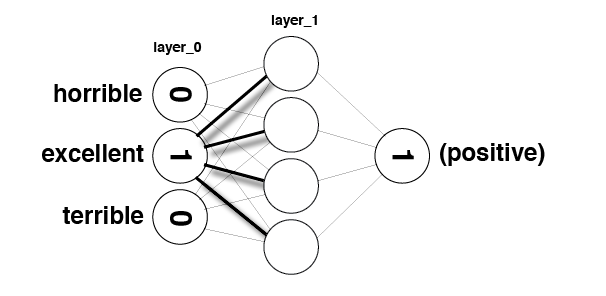

In [79]:
Image(filename='pics/sentiment_network_sparse.png')

In [81]:
# Get the words that have the most similar vectors

def get_most_similar_words(focus = "horrible"):
    most_similar = Counter()

    for word in mlp_full.word2index.keys():
        most_similar[word] = np.dot(mlp_full.weights_0_1[mlp_full.word2index[word]],
                                    mlp_full.weights_0_1[mlp_full.word2index[focus]])
    
    return most_similar.most_common()

In [82]:
get_most_similar_words("excellent")

[('excellent', 0.1367295075735247),
 ('perfect', 0.12548286087225943),
 ('amazing', 0.0918276339259997),
 ('today', 0.09022366269441418),
 ('wonderful', 0.08935597696221462),
 ('fun', 0.08750446667420683),
 ('great', 0.08714175888229204),
 ('best', 0.08581088561788061),
 ('liked', 0.07769762912384343),
 ('definitely', 0.07662878140696602),
 ('brilliant', 0.07342385876927902),
 ('loved', 0.07328542892812213),
 ('favorite', 0.07278113603616074),
 ('superb', 0.07173620717850504),
 ('fantastic', 0.0709221919162662),
 ('job', 0.06916061720763406),
 ('incredible', 0.06642407795261442),
 ('enjoyable', 0.06563256050288882),
 ('rare', 0.06481921266261509),
 ('highly', 0.0638894533509705),
 ('enjoyed', 0.062127546101812925),
 ('wonderfully', 0.06205517860409015),
 ('perfectly', 0.06109320881188737),
 ('fascinating', 0.06066354793749386),
 ('bit', 0.059655427045653034),
 ('gem', 0.05951085929615678),
 ('outstanding', 0.05886080814708302),
 ('beautiful', 0.05861393470316205),
 ('surprised', 0.0582

In [83]:
get_most_similar_words("terrible")

[('worst', 0.1696610725904985),
 ('awful', 0.12026847019691246),
 ('waste', 0.11945367265311008),
 ('poor', 0.0927588875744355),
 ('terrible', 0.09142538719772797),
 ('dull', 0.08420927167822363),
 ('poorly', 0.08124154451604204),
 ('disappointment', 0.08006475962136872),
 ('fails', 0.07859977372333751),
 ('disappointing', 0.07733948548032335),
 ('boring', 0.0771278587480129),
 ('unfortunately', 0.07550244970585905),
 ('worse', 0.07060183536419468),
 ('mess', 0.07056429962359043),
 ('stupid', 0.06948482283254306),
 ('badly', 0.06688890366622857),
 ('annoying', 0.06568702190337418),
 ('bad', 0.06309381453757215),
 ('save', 0.06288059749586576),
 ('disappointed', 0.06269235381207289),
 ('wasted', 0.06138718302805128),
 ('supposed', 0.060985452957725145),
 ('horrible', 0.060121772339380146),
 ('laughable', 0.05869840628546764),
 ('crap', 0.05810452866788457),
 ('basically', 0.057218840369636176),
 ('nothing', 0.05715822004303422),
 ('ridiculous', 0.05690548106893144),
 ('lacks', 0.0557665

In [84]:
import matplotlib.colors as colors

words_to_visualize = list()
for word, ratio in pos_neg_ratios.most_common(500):
    if(word in mlp_full.word2index.keys()):
        words_to_visualize.append(word)
    
for word, ratio in list(reversed(pos_neg_ratios.most_common()))[0:500]:
    if(word in mlp_full.word2index.keys()):
        words_to_visualize.append(word)

In [85]:
pos = 0
neg = 0

colors_list = list()
vectors_list = list()
for word in words_to_visualize:
    if word in pos_neg_ratios.keys():
        vectors_list.append(mlp_full.weights_0_1[mlp_full.word2index[word]])
        if(pos_neg_ratios[word] > 0):
            pos+=1
            colors_list.append("#00ff00")
        else:
            neg+=1
            colors_list.append("#000000")

In [86]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(vectors_list)

In [87]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="vector T-SNE for most polarized words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_to_visualize,
                                    color=colors_list))

p.scatter(x="x1", y="x2", size=8, source=source, fill_color="color")

word_labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(word_labels)

show(p)

# green indicates positive words, black indicates negative words

---